TL;DR: 
*  [Area Under the Receiver Operating Characteristic Curve (AUC-ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) is a popular evaluation metric for binary classifiers. 
*  In this colab, we demonstrate a technique to segment the AUC-ROC along human-interpretable dimensions. 
* AUC-ROC is not an additive/linear function over the data samples, therefore such segmenting the overall AUC-ROC is different from tabulating the AUC-ROC of data seg-ments. 
* To segment the overall AUC-ROC, we must first identify attribute the overall AUC-ROC to individual examples. 
* AUC-ROC is already linear over pairs of examples. To identify credit for an individual example we split credit for pair evenly over the members of a pair.
* We automatically slice these attributions, either for a single example or a pair, using decision trees by making the tree predict these attributions.
* We use the notion of honest estimates along with a t-test to mitigate false discovery, i.e., if the distribution of samples for a segment differs between the dataset used for slicing, and the one which was kept aside, we warn the analyst that the result may be noisy.
* We use also compare two models by diffing the AUC Attributions.
* This analysis can be used to identify the robustness of the overal AUC to distribution shifts, and to identify headroom for improvement.


In [1]:
#@title imports
import collections
import os
import time
import zipfile
import numpy as np
import pandas as pd

from colabtools import adhoc_import
from colabtools import drive
from colabtools import googlefiles
from google3.pyglib import resources
from google3.pyglib import gfile

import seaborn as sns
from scipy.stats import pearsonr

from sklearn import tree
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn import utils


import time
from sortedcontainers import SortedList
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss

from matplotlib import pyplot as plt

We analyze three different binary classification tasks.
The next sections sets up the data; you can modify this set up to analyze your own model.

#data

In [2]:
DATASETS_DIR = '/tmp/datasets'
! mkdir $DATASETS_DIR

mkdir: cannot create directory ‘/tmp/datasets’: File exists


In [3]:
#@title Data reading utils
def read_from_drive(file_id, local_path):
  byte_string = drive.LoadFile(file_id=file_id)
  
  with gfile.Open(local_path, 'wb') as f:
    f.write(byte_string)

def get_df_from_drive(file_id):
  filepath = os.path.join(DATASETS_DIR, file_id)
  read_from_drive(file_id, filepath)
  return pd.read_csv(filepath)

## Preprocess

In [4]:
#@title Preprocess Functions

def preprocess_lending(accepted):
  missing_data = accepted.isnull().sum().sort_values(ascending=False)
  drop_columns = list(missing_data[missing_data > accepted.shape[0] * 0.1].index) # drop columns where at least 10% of data is missing
  accepted = accepted.drop(drop_columns, axis = 1)

  accepted.term = accepted.term.apply(str)
  accepted['term'] = accepted['term'].apply(lambda x: x.strip().split(" ")[0])
  accepted.issue_d = pd.to_datetime(accepted.issue_d)
  accepted['issue_yr'] = accepted.issue_d.dt.year

  accepted = accepted.drop(['title', 'funded_amnt'], axis = 1)
  accepted = accepted.drop(['out_prncp_inv','total_rec_prncp','total_pymnt_inv'], axis = 1)
  accepted = accepted.drop(['fico_range_low', 'last_fico_range_low',
                          'avg_cur_bal',
                          'addr_state', 'initial_list_status', 'pymnt_plan',
                          'application_type', 'hardship_flag', 'disbursement_method',
                            'debt_settlement_flag','sub_grade',
                          'zip_code', 'id','policy_code','tax_liens', 'tax_liens'], axis = 1)
  
  accepted.home_ownership = accepted.home_ownership.replace(['ANY', 'NONE','OTHER'], 'RENT')

  accepted['earliest_cr_line'] = pd.to_datetime(accepted.earliest_cr_line)
  accepted['early_cr_yr'] = accepted.earliest_cr_line.dt.year

  median_year = accepted.emp_length.value_counts(ascending = False).index[0]
  accepted.loc[:, 'emp_length'] = accepted.loc[:, 'emp_length'].fillna(median_year)

  accepted.emp_length = accepted.emp_length.replace(['10+ years'], '10 years')
  accepted.emp_length = accepted.emp_length.replace(['< 1 year'], '0 years')
  accepted.emp_length = accepted.emp_length.apply(lambda x: int(str(x).split(' ')[0]))
  accepted.loc[:, 'emp_title'] = accepted.loc[:, 'emp_title'].fillna('other')
  accepted.emp_title = accepted.emp_title.apply(lambda x: x.lower())
  accepted.emp_title = accepted.emp_title.replace(['lpn','registered nurse', 'rn'], 'nurse')

  leq1mil = accepted['annual_inc'] <= 1e6
  accepted = accepted[leq1mil]
  accepted = accepted[accepted.dti < 100.0]
  accepted['verified'] = accepted['verification_status'] == 'Verified'

  # Eliminate active loans
  accepted = accepted.loc[accepted.loan_status != 'Current', :]
  # Set all targets to 1
  accepted['target'] = 1
  # Unpaid loans are set to 0.
  accepted.loc[(accepted.loan_status == 'Fully Paid') | (accepted.loan_status == 'In Grace Period') 
              | (accepted.loan_status == 'Does not meet the credit policy. Status:Fully Paid')
                  , 'target'] = 0

  # Remove loan_status since it is the label.
  # Remove emp title and url as they have too many unique values.
  accepted = accepted.drop(['loan_status', 'emp_title', 'url'], axis=1)

  # Drop features that may not be known to investors at the time of issue.
  # from: https://www.kaggle.com/pileatedperch/predicting-charge-off-from-initial-listing-data
  keep_cols = ['addr_state', 'annual_inc', 'application_type', 'dti',
               'earliest_cr_line', 'early_cr_yr', 'emp_length', 'emp_title', 'fico_range_high',
               'fico_range_low', 'grade', 'home_ownership', 'id',
               'initial_list_status', 'installment', 'int_rate',
               'issue_d', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc',
               'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal',
               'revol_util', 'sub_grade', 'target', 'term', 'title', 'total_acc',
               'verification_status', 'verified', 'zip_code']
  drop_cols = [col for col in accepted.columns if col not in keep_cols]
  accepted.drop(labels=drop_cols, axis=1, inplace=True)
  return accepted

def preprocess_bank_marketing(df):
  df['target'] = np.where(df.y=='yes', 1, 0)
  del df['y']
  return df

def preprocess_census(df):
  df.columns = [
      "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
      "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
      "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
  ]
  df.drop('fnlwgt', axis=1, inplace=True)
  df['Income'] = np.where(df.Income == ' >50K', 1, 0)
  return df

In [5]:
LENDING_FILE_ID = '16z6xUwCB2LfHc_K24rU6DisGMhuJ-WQO'  # label: target
BANK_MARKETING_FILE_ID = '1gcTcvXLJwl1UorLKFIf-fFe4iopuo2Zd'  # label: y
CENSUS_FILE_ID = '1SYh_nA-NKPGtiAxn2rvaDdWWo7DxaOS2'  # label: Income

In [6]:
#@title Dataset Parameters

dataset = 'Census' #@param ["Lending", "Bank Marketing", "Census"]

if dataset == 'Lending':
  preprocess_fn = preprocess_lending
  fileid = LENDING_FILE_ID
  label_column = 'target'
elif dataset == 'Bank Marketing':
  preprocess_fn = preprocess_bank_marketing
  fileid = BANK_MARKETING_FILE_ID
  label_column = 'target'
elif dataset == 'Census':
  preprocess_fn = preprocess_census
  fileid = CENSUS_FILE_ID
  label_column = 'Income'

In [7]:
df = get_df_from_drive(fileid)
df = preprocess_fn(df)

# MANY ROWS MIGHT BE DROPPED
df.dropna(inplace=True)

Beginning OAuth2 authorization process ...
Authentication successful.


We train three different models for each task, a large random forest, a small random forest and a logistic regression model. You can replace this with your model.

#train

In [8]:
#@title Training utils

def create_pipeline_with_one_hot(df: pd.DataFrame, model, label_name: str):
  """Creates a pipeline by converting categorical features to one hot.
  
  Date columns are being dropped and numeric columns as passed through.
  """
  # Assuming the label is the last column
  train_columns = df.columns.tolist()
  train_columns.remove(label_name)
  is_cat = np.array([dt.kind == 'O' for dt in df[train_columns].dtypes])
  cat_cols = df[train_columns].columns.values[is_cat]
  is_num = np.array([dt.kind == 'f' or dt.kind == 'i' for dt in df[train_columns].dtypes])
  num_cols = df[train_columns].columns.values[is_num]
  # Date columns are effectively dropped.
  transformers = [
      ('cat', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_cols),
      ('num', FunctionTransformer(), num_cols)
  ]
  ct = ColumnTransformer(transformers=transformers)
  return Pipeline([
      ('ct', ct),
      ('rf', model),
  ])

def split_data(df: pd.DataFrame, label_column: str):
  """Splits the dataframe into train and test.
  Args:
    df: Dataframe representing the whole dataset.
    label_column: Name of the label column.
  Returns: 
    Tuple of training features, test features, training labels, and test labels.
  """
  return train_test_split(df[df.columns.difference([label_column])], df[label_column], test_size = 0.2, random_state = 42)

def add_predictions_to_df(model, df, columns, suffix=''):
  # To make this function idempotent
  df_copy = df.copy()
  df_copy['predictions' + suffix] = model.predict(df[columns])
  df_copy['probabilities' + suffix] = model.predict_proba(df[columns])[:, 1]
  return df_copy

In [17]:
carry_around_dims = []

In [18]:
carry_around_df = df[carry_around_dims]
df = df[df.columns.difference(carry_around_dims)]

##logistic

In [20]:
pipe = create_pipeline_with_one_hot(df, LogisticRegression(random_state=1234, max_iter=100), label_column)
train_features, test_features, train_labels, test_labels = split_data(df, label_column)

_ = pipe.fit(train_features[train_features.columns.difference(carry_around_dims)], train_labels)

/usr/local/google/_blaze_besim/49cbd36a6f46e81b32ba2ad0d659c96d/execroot/google3/blaze-out/k8-fastbuild/bin/learning/deepmind/public/tools/ml_python/ml_notebook.runfiles/google3/third_party/py/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [21]:
suffix = '_logistic'

train_features = add_predictions_to_df(pipe, train_features, train_features.columns.difference(carry_around_dims), suffix)
test_features = add_predictions_to_df(pipe, test_features, test_features.columns.difference(carry_around_dims), suffix)

carry_around_df = carry_around_df.merge(pd.concat([train_features,test_features])[['predictions' + suffix, 'probabilities' + suffix]], right_index=True, left_index=True, suffixes=['',''])
carry_around_dims += ['predictions' + suffix, 'probabilities' + suffix]

In [22]:
print(suffix + ' test auc: ', roc_auc_score(test_labels, test_features['probabilities' + suffix]))
print(suffix + ' train auc: ', roc_auc_score(train_labels, train_features['probabilities' + suffix]))

_logistic test auc:  0.8792277839983712
_logistic train auc:  0.8788654369820184


##random forest

In [23]:
pipe = create_pipeline_with_one_hot(df, RandomForestClassifier(n_estimators=50, random_state=1234), label_column)

_ = pipe.fit(train_features[train_features.columns.difference(carry_around_dims)], train_labels)

In [24]:
suffix = '_forest'

train_features = add_predictions_to_df(pipe, train_features, train_features.columns.difference(carry_around_dims), suffix)
test_features = add_predictions_to_df(pipe, test_features, test_features.columns.difference(carry_around_dims), suffix)

carry_around_df = carry_around_df.merge(pd.concat([train_features,test_features])[['predictions' + suffix, 'probabilities' + suffix]], right_index=True, left_index=True, suffixes=['',''])
carry_around_dims += ['predictions' + suffix, 'probabilities' + suffix]

In [25]:
print(suffix + ' test auc: ', roc_auc_score(test_labels, test_features['probabilities' + suffix]))
print(suffix + ' train auc: ', roc_auc_score(train_labels, train_features['probabilities' + suffix]))

_forest test auc:  0.8921728038477198
_forest train auc:  0.9974539961970948


##simple random forest

In [26]:
if dataset == 'Lending':
  simple_columns = ['fico_range_high', 'int_rate', 'loan_amnt', 'purpose', 'target']
elif dataset == 'Census':
  simple_columns = ['CapitalGain', 'Age', 'EducationNum', 'Income']

In [27]:
df_simple = df[simple_columns]

In [28]:
pipe = create_pipeline_with_one_hot(df_simple, RandomForestClassifier(
    n_estimators=100, max_depth=5, bootstrap=False, max_features=None, random_state=1234), label_column)
train_features, test_features, train_labels, test_labels = split_data(df_simple, label_column)

_ = pipe.fit(train_features[train_features.columns.difference(carry_around_dims)], train_labels)

In [29]:
suffix = '_simple'

In [30]:
train_features = add_predictions_to_df(pipe, train_features, train_features.columns.difference(carry_around_dims), suffix)
test_features = add_predictions_to_df(pipe, test_features, test_features.columns.difference(carry_around_dims), suffix)

carry_around_df = carry_around_df.merge(pd.concat([train_features, test_features])[['predictions' + suffix, 'probabilities' + suffix]], right_index=True, left_index=True, suffixes=['',''])
carry_around_dims += ['predictions' + suffix, 'probabilities' + suffix]

In [31]:
print(suffix + ' test auc: ', roc_auc_score(test_labels, test_features['probabilities' + suffix]))
print(suffix + ' train auc: ', roc_auc_score(train_labels, train_features['probabilities' + suffix]))

_simple test auc:  0.8331229005496742
_simple train auc:  0.8300811976738806


##merge carry around features

In [32]:
train_features, test_features, train_labels, test_labels = split_data(df, label_column)

In [33]:
train_features = train_features.merge(carry_around_df, left_index=True, right_index=True, suffixes=['',''])
test_features = test_features.merge(carry_around_df, left_index=True, right_index=True, suffixes=['',''])
# Add labels to the dataframe
train_features[label_column] = train_labels
test_features[label_column] = test_labels

We perform AUC attribution for individual examples. We also compute attributions for log loss and gini impurity; these are the objective functions of logistic regression and random-forests respectively.

#attribution

In [34]:
#@title AUC attribution

def calculate_auc_attribution(positive_scores, negative_scores):
  """Makes AUC attributions to each input point.

  Args:
    positive_scores: Sorted list of predictions for the positive class.
    negative_scores: Sorted list of predictions for the negative class.
  Returns:
    Tuple of attributions for positive scores and negative scores respectively.  
  """
  neg_attrs, pos_attrs = [], []
  neg_index, pos_index = 0, 0
  while True:
    if positive_scores[pos_index] > negative_scores[neg_index]:
      neg_attrs.append(pos_index)
      neg_index += 1
    elif positive_scores[pos_index] < negative_scores[neg_index]:
      pos_attrs.append(neg_index)
      pos_index += 1
    else:  # Tie
      # Advance both at the same time.
      next_pos_tie_index = pos_index
      for next_pos_tie_index in range(pos_index, len(positive_scores)):
        if positive_scores[next_pos_tie_index] != negative_scores[neg_index]:
          break
      else:
        next_pos_tie_index = len(positive_scores)
      next_neg_tie_index = neg_index
      for next_neg_tie_index in range(neg_index, len(negative_scores)):
        if negative_scores[next_neg_tie_index] != positive_scores[pos_index]:
          break
      else:
        next_neg_tie_index = len(negative_scores)
      pos_attr = neg_index + (next_neg_tie_index - neg_index) * 0.5
      neg_attr = pos_index + (next_pos_tie_index - pos_index) * 0.5
      for i in range(neg_index, next_neg_tie_index):
        neg_attrs.append(neg_attr)
      for i in range(pos_index, next_pos_tie_index):
        pos_attrs.append(pos_attr)
      neg_index = next_neg_tie_index
      pos_index = next_pos_tie_index

    # One group is exhausted. Attribute the unfinished list.
    if pos_index == len(positive_scores):
      for i in range(neg_index, len(negative_scores)):
        neg_attrs.append(pos_index)
      break
    if neg_index == len(negative_scores):
      for i in range(pos_index, len(positive_scores)):
        pos_attrs.append(neg_index)
      break

  total_pairs = len(positive_scores) * len(negative_scores) * 2  # DIVIDE BY 2.

  adjusted_neg_attrs = []
  for neg_attr in neg_attrs:
    adjusted_neg_attrs.append(len(positive_scores) - neg_attr)
  return np.array(pos_attrs) / total_pairs, np.array(adjusted_neg_attrs) / total_pairs

def add_auc_attributions_to_df(df, suffix):
  """Adds auc attributions for each example as a new column named auc_attr_*."""
  print('AUC score for the given Dataframe: %f.' % roc_auc_score(
      df[label_column], df['probabilities' + suffix]))
  negative_cases = df[df[label_column] == 0]
  positive_cases = df[df[label_column] == 1]
  negative_cases = negative_cases.sort_values('probabilities' + suffix)
  positive_cases = positive_cases.sort_values('probabilities' + suffix)
  p, n = calculate_auc_attribution(
      positive_cases['probabilities' + suffix].tolist(),
       negative_cases['probabilities' + suffix].tolist())
  print('Sum of AUC attributions: %f.' % (np.sum(n) + np.sum(p)))
  positive_cases['auc_attr' + suffix] = p
  negative_cases['auc_attr' + suffix] = n
  return positive_cases.append(negative_cases, ignore_index=False)

In [35]:
#@title Attach attribution scores

def add_auc_attributions_fraction_of_pairs(df, label_column, suffix):
  """Normalize AUC attribution based on positive and negative counts."""
  p = np.sum(df[label_column] == 1)
  n = np.sum(df[label_column] == 0)
  weight = np.where(df[label_column] == 1, p, n)
  
  df['auc_frac_attr' + suffix] = df['auc_attr' + suffix] * weight
  return df 

test_features = add_auc_attributions_to_df(test_features, "_logistic")
test_features = add_auc_attributions_to_df(test_features, "_forest")
test_features = add_auc_attributions_to_df(test_features, "_simple")

test_features = add_auc_attributions_fraction_of_pairs(
    test_features, label_column, "_logistic")
test_features = add_auc_attributions_fraction_of_pairs(
    test_features, label_column, "_forest")
test_features = add_auc_attributions_fraction_of_pairs(
    test_features, label_column, "_simple")

# Scale up attributions to avoid numerical instability.
multiplier = np.sum(df[label_column] == 1) * np.sum(df[label_column] == 0)
test_features['auc_attr' + '_logistic'] *= multiplier
test_features['auc_attr' + '_forest'] *= multiplier
test_features['auc_attr' + '_simple'] *= multiplier

AUC score for the given Dataframe: 0.879228.
Sum of AUC attributions: 0.879228.
AUC score for the given Dataframe: 0.892173.
Sum of AUC attributions: 0.892173.
AUC score for the given Dataframe: 0.833123.
Sum of AUC attributions: 0.833123.


In [36]:
#@title LogLoss attribution
def logloss(true_label, predicted, eps=1e-15):
  p = np.clip(predicted, eps, 1 - eps)
  return np.where(true_label == 1, -np.log(p), -np.log(1-p))
  if true_label == 1:
    return -np.log(p)
  else:
    return -np.log(1 - p)

test_features['logloss_logistic'] = logloss(test_features[label_column], test_features.probabilities_logistic)
test_features['logloss_forest'] = logloss(test_features[label_column], test_features.probabilities_forest)
test_features['logloss_simple'] = logloss(test_features[label_column], test_features.probabilities_simple)
 

In [37]:
print(np.mean(test_features.logloss_logistic))
print(np.mean(test_features.logloss_forest))
print(np.mean(test_features.logloss_simple))

0.35954021690426646
0.5410857578550053
0.39155512831437234


In [38]:
# @title Gini attribution
def gini_attribution(df, suffix):
  assert 'probabilities' + suffix in df, "probabilities not in the df."
  df['gini' + suffix] = (
      (1 - df[label_column]) * df['probabilities' + suffix] + 
      df[label_column] * (1 - df['probabilities' + suffix]))
  return df

test_features = gini_attribution(test_features, '_logistic')
test_features = gini_attribution(test_features, '_forest')
test_features = gini_attribution(test_features, '_simple')

In [39]:
print(test_features.gini_logistic.mean())
print(test_features.gini_forest.mean())
print(test_features.gini_simple.mean())

0.23980073063057955
0.1934329261338178
0.25353388081119704


In [40]:
# @title Print metrics for each model.
print("AUC Score")
print("Random Forest:", roc_auc_score(test_features[label_column], test_features.probabilities_forest))
print("Logistic Regression:", roc_auc_score(test_features[label_column], test_features.probabilities_logistic))
print("Simple Model:", roc_auc_score(test_features[label_column], test_features.probabilities_simple))

print("Logloss")
print("Random Forest:", test_features.logloss_forest.mean())
print("Logistic Regression:", test_features.logloss_logistic.mean())
print("Simple Model:", test_features.logloss_simple.mean())

print("GINI")
print("Random Forest:", test_features.gini_forest.mean())
print("Logistic Regression:", test_features.gini_logistic.mean())
print("Simple Model:", test_features.gini_simple.mean())

AUC Score
Random Forest: 0.8921728038477198
Logistic Regression: 0.8792277839983712
Simple Model: 0.8331229005496742
Logloss
Random Forest: 0.5410857578550053
Logistic Regression: 0.35954021690426646
Simple Model: 0.39155512831437234
GINI
Random Forest: 0.1934329261338178
Logistic Regression: 0.23980073063057955
Simple Model: 0.25353388081119704


Next, we slice the AUC attributions using a single decision tree

#Slice

#slicing tree

In [41]:
#@title Build Tree function
def build_tree(df: pd.DataFrame, target_column: str, input_columns, 
               min_samples_leaf=5000, max_depth=3):
  """Builds a slicing tree.
  
  Returns:
    A tuple of the tree itself and the feature names.
  """
  is_cat = np.array([dt.kind == 'O' for dt in df[input_columns].dtypes])
  cat_cols = df[input_columns].columns.values[is_cat]
  is_num = np.array([dt.kind == 'f' or dt.kind == 'i' for dt in df[input_columns].dtypes])
  num_cols = df[input_columns].columns.values[is_num]
  # Date and other type of columns are effectively dropped.
  transformers = [
      ('cat', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_cols),
      ('num', FunctionTransformer(), num_cols)
  ]
  ct = ColumnTransformer(transformers=transformers)
  treg = tree.DecisionTreeRegressor(min_samples_leaf=min_samples_leaf, max_depth=max_depth,
                                    random_state=1234)
  treg.fit(ct.fit_transform(df[input_columns]), df[target_column])
  if len(cat_cols) > 0:
    feature_names = ct.transformers_[0][1].get_feature_names(cat_cols).tolist()
  else:
    feature_names = []
  feature_names += num_cols.tolist()
  return treg, feature_names, ct

In [43]:
#@title Per Node Plotting Utils

from sklearn.tree._export import _MPLTreeExporter
from sklearn.tree import _criterion
from sklearn.tree import _export
from sklearn.tree import _tree
from scipy import stats


class _MPLTreeExporterOverride(_MPLTreeExporter):
  def node_to_str(self, tree, node_id, criterion):
      # Generate the node content string
      if tree.n_outputs == 1:
          value = tree.value[node_id][0, :]
      else:
          value = tree.value[node_id]

      # Should labels be shown?
      labels = (self.label == 'root' and node_id == 0) or self.label == 'all'

      characters = self.characters
      node_string = characters[-1]

      # Write node ID
      if self.node_ids:
          if labels:
              node_string += 'node '
          node_string += characters[0] + str(node_id) + characters[4]

      # Write decision criteria
      if tree.children_left[node_id] != _tree.TREE_LEAF:
          # Always write node decision criteria, except for leaves
          if self.feature_names is not None:
              feature = self.feature_names[tree.feature[node_id]]
          else:
              feature = "X%s%s%s" % (characters[1],
                                      tree.feature[node_id],
                                      characters[2])
          node_string += '%s %s %s%s' % (feature,
                                          characters[3],
                                          round(tree.threshold[node_id],
                                                self.precision),
                                          characters[4])

      # Don't Write impurity
      """
      if self.impurity:
          if isinstance(criterion, _criterion.FriedmanMSE):
              criterion = "friedman_mse"
          elif not isinstance(criterion, str):
              criterion = "impurity"
          if labels:
              node_string += '%s = ' % criterion
          node_string += (str(round(tree.impurity[node_id], self.precision))
                          + characters[4])
      """

      # Write node sample count
      if labels:
          node_string += 'samples = '
      if self.proportion:
          percent = (100. * tree.n_node_samples[node_id] /
                      float(tree.n_node_samples[0]))
          node_string += (str(round(percent, 1)) + '%' +
                          characters[4])
      else:
          node_string += (str(tree.n_node_samples[node_id]) +
                          characters[4])

      ### OVERRIDE CHANGE BEGIN
      if self.base_metric_per_node:
        node_string += '%s = ' % self.base_metric_name
        node_string += str(
            round(np.mean(
                self.base_metric_per_node[node_id]), 5)) + characters[4]
      if self.honest_metric_per_node:
        node_string += '%s (honest) = ' % self.metric_name
        node_string += str(
            round(np.mean(
                self.honest_metric_per_node[node_id]), 5)) + characters[4]
      ### OVERRIDE CHANGE END

      # Write node class distribution / regression value
      if self.proportion and tree.n_classes[0] != 1:
          # For classification this will show the proportion of samples
          value = value / tree.weighted_n_node_samples[node_id]
      if labels:
          node_string += '%s = ' % self.metric_name  # Also OVERRIDE change.
      if tree.n_classes[0] == 1:
          # Regression
          value_text = np.around(value, self.precision)
      elif self.proportion:
          # Classification
          value_text = np.around(value, self.precision)
      elif np.all(np.equal(np.mod(value, 1), 0)):
          # Classification without floating-point weights
          value_text = value.astype(int)
      else:
          # Classification with floating-point weights
          value_text = np.around(value, self.precision)
      # Strip whitespace
      value_text = str(value_text.astype('S32')).replace("b'", "'")
      value_text = value_text.replace("' '", ", ").replace("'", "")
      if tree.n_classes[0] == 1 and tree.n_outputs == 1:
          value_text = value_text.replace("[", "").replace("]", "")
      value_text = value_text.replace("\n ", characters[4])
      node_string += value_text + characters[4]

      # Clean up any trailing newlines
      if node_string.endswith(characters[4]):
          node_string = node_string[:-len(characters[4])]

      return node_string + characters[5]

  def get_color(self, value, node_id):
        # Find the appropriate color & intensity for a node
        if self.colors['bounds'] is None:
            # Classification tree
            color = list(self.colors['rgb'][np.argmax(value)])
            sorted_values = sorted(value, reverse=True)
            if len(sorted_values) == 1:
                alpha = 0
            else:
                alpha = ((sorted_values[0] - sorted_values[1])
                         / (1 - sorted_values[1]))
        else:
            # Regression tree or multi-output
            ### OVERRIDE ###
            color = list(self.colors['rgb'][0])
            alpha = ((value - self.colors['bounds'][0]) /
                     (self.colors['bounds'][1] - self.colors['bounds'][0]))
            if self.honest_metric_per_node:
              # Get (1 - p-value) as the alpha.
              if stats.ttest_ind(self.metric_per_node[node_id],
                                 self.honest_metric_per_node[node_id])[1] < 0.05:
                alpha = 1
              else:
                alpha = 0
              # alpha = 1 - stats.ttest_ind(self.metric_per_node[node_id],
              #                            self.honest_metric_per_node[node_id])[1]
            ### OVERRIDE END ###
        # unpack numpy scalars
        alpha = float(alpha)
        # compute the color as alpha against white
        color = [int(round(alpha * c + (1 - alpha) * 255, 0)) for c in color]
        # Return html color code in #RRGGBB format
        return '#%2x%2x%2x' % tuple(color)

  def get_fill_color(self, tree, node_id):
        # Fetch appropriate color for node
        if 'rgb' not in self.colors:
            # Initialize colors and bounds if required
            self.colors['rgb'] = _export._color_brew(tree.n_classes[0])
            if tree.n_outputs != 1:
                # Find max and min impurities for multi-output
                self.colors['bounds'] = (np.min(-tree.impurity),
                                         np.max(-tree.impurity))
            elif (tree.n_classes[0] == 1 and
                  len(np.unique(tree.value)) != 1):
                # Find max and min values in leaf nodes for regression
                self.colors['bounds'] = (np.min(tree.value),
                                         np.max(tree.value))
        if tree.n_outputs == 1:
            node_val = (tree.value[node_id][0, :] /
                        tree.weighted_n_node_samples[node_id])
            if tree.n_classes[0] == 1:
                # Regression
                node_val = tree.value[node_id][0, :]
        else:
            # If multi-output color node by impurity
            node_val = -tree.impurity[node_id]
        return self.get_color(node_val, node_id)


def get_samples_ids_through_node(tree, df):
  """Figures out which samples go through each node in a tree.
  Returns a dictionary where the key is the node index, values is a list of
  row numbers that go through that node.
  """
  dec_paths = tree.decision_path(df)

  samples = collections.defaultdict(list)
  for d, dec in enumerate(dec_paths):
    for i in range(tree.tree_.node_count):
      if dec.toarray()[0][i] == 1:
        samples[i].append(d) 
  return samples


def get_metric_per_node(tree, tree_dims, df, metric_name, col_transformer=None):
  """Calculates the desired metric for each tree node."""
  if col_transformer:
    feats = col_transformer.transform(df[tree_dims])
  else:
    feats = df[tree_dims]
  sample_ids = get_samples_ids_through_node(tree, feats)

  metric_per_node = []
  for i in range(tree.tree_.node_count):
    samples_through_node = df.iloc[sample_ids[i], :]
    # metric_per_node.append(np.mean(samples_through_node[metric_name]))
    metric_per_node.append(samples_through_node[metric_name])
  return metric_per_node



def plot_tree_override(decision_tree, *, max_depth=None, feature_names=None,
              class_names=None, label='all', filled=False,
              impurity=True, node_ids=False,
              proportion=False, rotate='deprecated', rounded=False,
              precision=3, ax=None, fontsize=None, decision_tree_dims=None,
              test_features=None, column_transformer=None,
              base_metric_to_record=None,
              metric_name_override='value',
              honest_sample=None, honest_metric=None):
  exporter = _MPLTreeExporterOverride(
      max_depth=max_depth, feature_names=feature_names,
      class_names=class_names, label=label, filled=filled,
      impurity=impurity, node_ids=node_ids,
      proportion=proportion, rotate=rotate, rounded=rounded,
      precision=precision, fontsize=fontsize)
  

  if base_metric_to_record:
    exporter.base_metric_per_node = get_metric_per_node(decision_tree,
                                                        decision_tree_dims,
                                                        test_features,
                                                        base_metric_to_record,
                                                        column_transformer)
  else:
    exporter.base_metric_per_node = None
  exporter.metric_per_node = get_metric_per_node(decision_tree,
                                                 decision_tree_dims,
                                                 test_features,
                                                 metric_name_override,
                                                 column_transformer)
  if honest_sample is not None:
    exporter.honest_metric_per_node = get_metric_per_node(decision_tree,
                                                          decision_tree_dims,
                                                          honest_sample,
                                                          honest_metric,
                                                          column_transformer)
  else:
    exporter.honest_metric_per_node = None

  exporter.base_metric_name = base_metric_to_record
  exporter.metric_name = metric_name_override
  return exporter.export(decision_tree, ax=ax)

In [44]:
test_features['delta_auc'] = (test_features['auc_attr_forest'] - test_features['auc_attr_simple']) * test_features.shape[0] 
test_features['delta_logloss'] = (test_features['logloss_forest'] - test_features['logloss_simple']) 

test_features['delta_auc'] = (test_features['auc_attr_forest'] - test_features['auc_attr_logistic']) * test_features.shape[0] 
test_features['delta_logloss'] = (test_features['logloss_forest'] - test_features['logloss_logistic'])
test_features['normalized_auc_attribution'] = test_features['auc_frac_attr_forest']

In [45]:
# @title Function for building and plotting the slicing tree.
def build_and_plot_slicing_tree(df, slicing_metric, slicing_dims, base_metric=None,
                                max_depth=3, min_samples_leaf=500,
                                honest_reporting=False):
  if honest_reporting:
    honest_sample1, honest_sample2 = train_test_split(df, test_size=0.5)
    tree_building_df = honest_sample1
    honest_sample = honest_sample2
  else:
    tree_building_df = df
    honest_sample = None
  tt, fnames, ct = build_tree(
      tree_building_df,
      slicing_metric,
      slicing_dims,
      min_samples_leaf=min_samples_leaf,
      max_depth=max_depth
      )

  # with plt.style.context('classic'):
  plt.figure(figsize=(20, 5))
  _ = plot_tree_override(tt, filled=True, fontsize=13,
                        feature_names=fnames, precision=3,
                        decision_tree_dims=slicing_dims,
                        test_features=tree_building_df,
                        column_transformer=ct,
                        base_metric_to_record=base_metric,
                        metric_name_override=slicing_metric,
                        honest_sample=honest_sample,
                        honest_metric=slicing_metric)

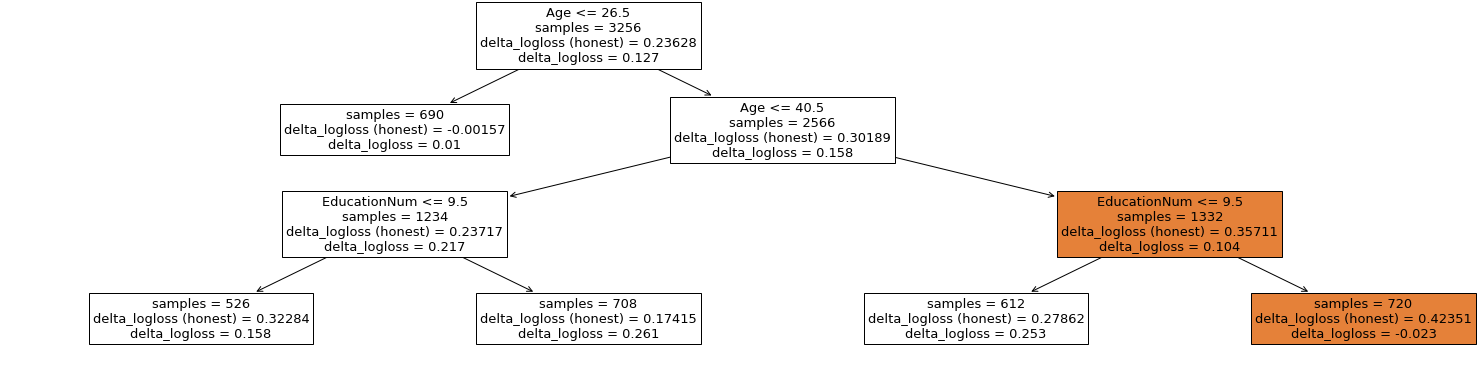

In [46]:
slicing_metric = 'delta_logloss' #@param ["delta_logloss", "delta_auc", "logloss", "auc_attr", "auc_surprise", "correlation", "mse", "precision", "recall", "normalized_auc_attribution"]
base_metric = '' #@param {type: "string"}
max_depth = 3 #@param
min_samples_leaf = 500 #@param
decision_tree_dims =  ['CapitalGain', 'Age', 'EducationNum']  #@param 

honest_reporting = True # @param {type: "boolean"}

build_and_plot_slicing_tree(test_features, slicing_metric, decision_tree_dims,
                            base_metric, max_depth, min_samples_leaf,
                            honest_reporting)

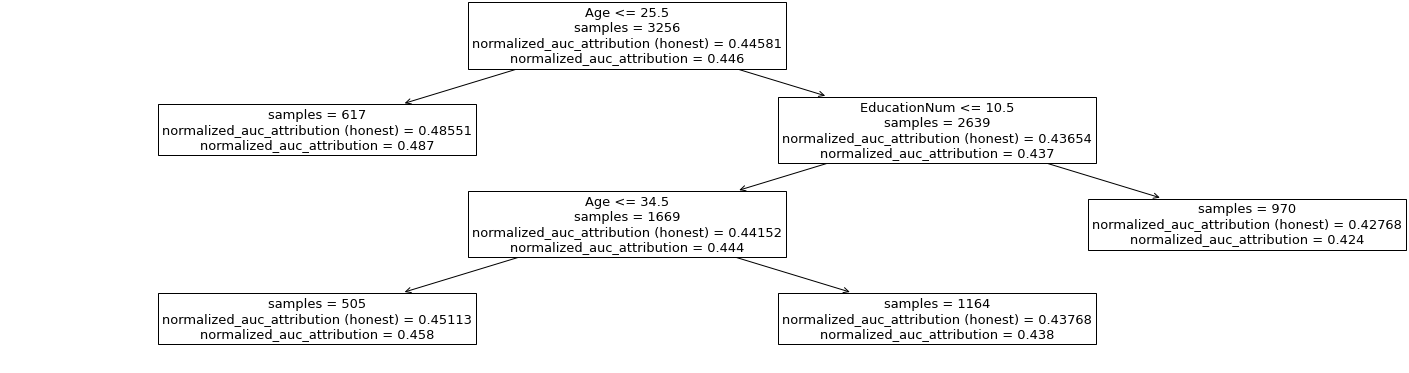

In [47]:
slicing_metric = 'normalized_auc_attribution' #@param ["delta_logloss", "delta_auc", "logloss", "auc_attr", "auc_surprise", "correlation", "mse", "precision", "recall", "normalized_auc_attribution"]
base_metric = '' #@param {type: "string"}
max_depth = 3 #@param
min_samples_leaf = 500 #@param
decision_tree_dims =  ['CapitalGain', 'Age', 'EducationNum']  #@param 

honest_reporting = True # @param {type: "boolean"}

build_and_plot_slicing_tree(test_features, slicing_metric, decision_tree_dims,
                            base_metric, max_depth, min_samples_leaf,
                            honest_reporting)

We analyze pairs of examples, one positive and one negative. The overall AUC is just the probability that a random such pair is ordered correctly, i.e., the model produces a higher score for the positive example of the pair. We slice these pairs, i.e., we categorize types of pairs that are easy to slice and those that are hard to slice.

### Pairwise Analysis

In [48]:
# @title Downsample the dataset.
sample_size = 10000 #@param
plotting_columns = test_features.columns[:13] # LENDING: test_features.columns[:23]

probability_column = 'probabilities_logistic'

if sample_size and sample_size < len(test_features):
  test_sample = utils.resample(
      test_features[[*plotting_columns, label_column, probability_column]],
      replace=False,
      n_samples=sample_size)
else:
  test_sample = test_features[[*plotting_columns, label_column, probability_column]]

negative_cases = test_sample[test_sample[label_column] == 0]
positive_cases = test_sample[test_sample[label_column] == 1]

positive_cases.columns = [name + '_pos' for name in positive_cases.columns]
negative_cases.columns = [name + '_neg' for name in negative_cases.columns]

# Needed to do cross join. This pandas version doesn't have cross join.
# Hence we do outer join with a fake joining column.
positive_cases['tmp'] = 1
negative_cases['tmp'] = 1

cartesian = negative_cases.merge(positive_cases, how='outer')
cartesian.drop('tmp', axis=1, inplace=True)

/usr/local/google/_blaze_besim/49cbd36a6f46e81b32ba2ad0d659c96d/execroot/google3/blaze-out/k8-fastbuild/bin/learning/deepmind/public/tools/ml_python/ml_notebook:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/google/_blaze_besim/49cbd36a6f46e81b32ba2ad0d659c96d/execroot/google3/blaze-out/k8-fastbuild/bin/learning/deepmind/public/tools/ml_python/ml_notebook:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [49]:
pair_label = 'AUC'
# Think harder on the ties.
cartesian[pair_label] = np.where(cartesian[probability_column + '_pos'] > cartesian[probability_column + '_neg'], 1, 0)

In [50]:
print("Sanity check for the pair labels.")
print("AUC of the sample:", np.mean(cartesian[pair_label]))
print("Overall model AUC:", roc_auc_score(test_features[label_column], test_features.probabilities_logistic))

Sanity check for the pair labels.
AUC of the sample: 0.8792215492671009
Overall model AUC: 0.8792277839983712


---
<font color='red'> The following cell might take a while.</font>

---

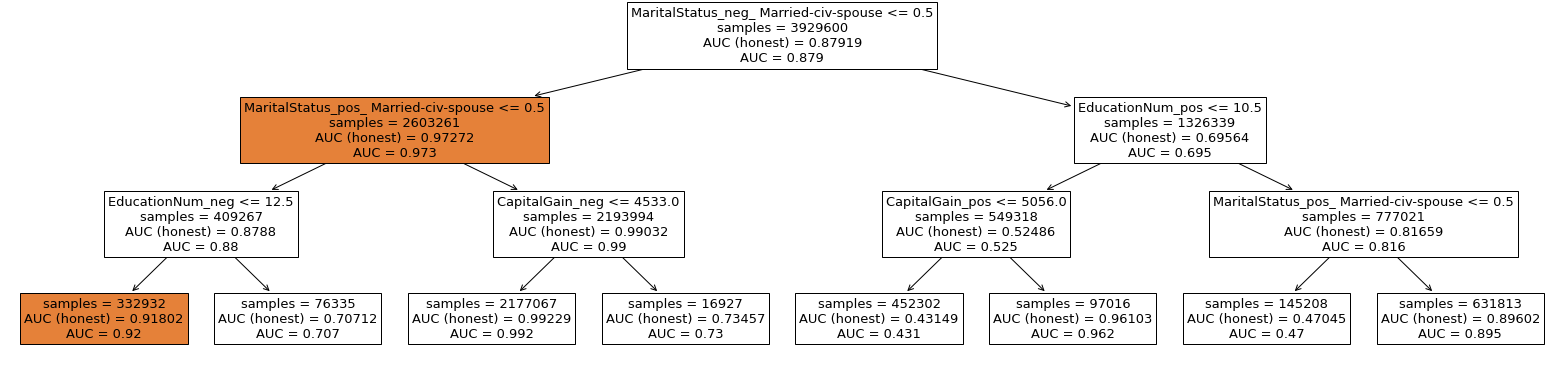

In [51]:
cartesian_cols = [col + '_pos' for col in plotting_columns]
cartesian_cols.extend([col + '_neg' for col in plotting_columns])
cartesian_cols.append(pair_label)

cartesian = cartesian[cartesian_cols]

honest_reporting = True # @param {type: "boolean"}

build_and_plot_slicing_tree(cartesian, pair_label,
                            cartesian.columns[:-1], None,
                            max_depth, min_samples_leaf, honest_reporting)

### Headroom Analysis

Text(0.5, 66.97222222222219, 'Negative Item')

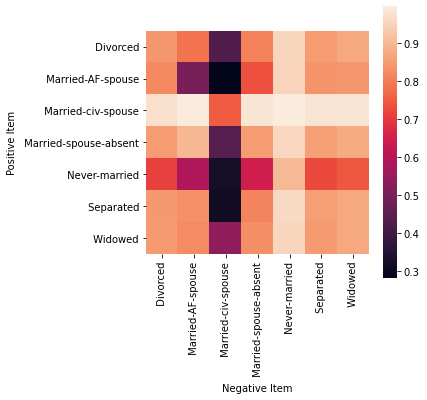

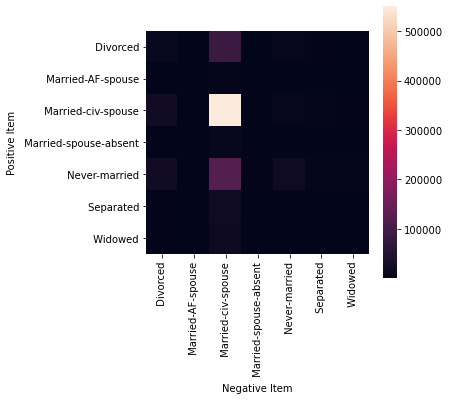

In [52]:
analysis_column = 'MaritalStatus' # @param {type: "string"}
leaves = test_features[analysis_column]
leaf_indeces = sorted(list(set(leaves)))
num_slices = len(leaf_indeces)

mat = np.zeros((num_slices, num_slices))
mat2 = np.zeros((num_slices, num_slices))
for i in range(num_slices):
  for j in range(num_slices):
    filtered = test_features[((leaves == leaf_indeces[i]) & (test_features[label_column] == 1)) |
                             ((leaves == leaf_indeces[j]) & (test_features[label_column] == 0))]
    try:
      mat[i, j] = roc_auc_score(filtered[label_column], filtered['probabilities_logistic'])
    except:
      mat[i, j] = np.nan
    p = filtered[label_column].sum()
    n = (1 - filtered[label_column]).sum()
    mat2[i, j] = n * p - mat[i, j] * n * p

plt.figure(figsize=(5, 5))
sns.matrix.heatmap(mat, square=True, xticklabels=leaf_indeces, yticklabels=leaf_indeces)
plt.ylabel('Positive Item')
plt.xlabel('Negative Item')
 
plt.figure(figsize=(5, 5))
sns.matrix.heatmap(mat2, square=True, xticklabels=leaf_indeces, yticklabels=leaf_indeces)
plt.ylabel('Positive Item')
plt.xlabel('Negative Item')

### Metric Correlation Analysis

In [53]:
print("GINI vs AUC correlation for Random Forest:", pearsonr(test_features.gini_forest, test_features.auc_attr_forest)[0])
print("GINI vs AUC correlation for Logistic Regression:", pearsonr(test_features.gini_logistic, test_features.auc_attr_logistic)[0])
print("Logloss vs AUC correlation for Random Forest:", pearsonr(test_features.logloss_forest, test_features.auc_attr_forest)[0])
print("Logloss vs AUC correlation for Logistic Regression:", pearsonr(test_features.logloss_logistic, test_features.auc_attr_logistic)[0])
print("Logloss vs normalized AUC correlation for Random Forest:", pearsonr(test_features.logloss_forest, test_features.auc_frac_attr_forest)[0])
print("Logloss vs normalized AUC correlation for Logistic Regression:", pearsonr(test_features.logloss_logistic, test_features.auc_frac_attr_logistic)[0])

GINI vs AUC correlation for Random Forest: 0.13824693053428042
GINI vs AUC correlation for Logistic Regression: 0.28351398534669237
Logloss vs AUC correlation for Random Forest: -0.057998234944792115
Logloss vs AUC correlation for Logistic Regression: 0.2261058368828327
Logloss vs normalized AUC correlation for Random Forest: -0.5222628390118051
Logloss vs normalized AUC correlation for Logistic Regression: -0.7251610687480482
